# Project for ADC

In [ ]:
import pygraphviz as pgv
import pandas as pd

format_str = "%H:%M, %d %B %Y"  # Define the expected format

# Function to read the file and extract SRC, TGT, VOT, DAT, YEA, RES, TXT
def extract_edges_from_file(file_path):
    edges = []
    with open(file_path, 'r') as f:
        entry = {}
        for line in f:
            # Read the lines and capture relevant fields
            if line.startswith("SRC:"):
                entry['SRC'] = line.strip().split(':')[1]
            elif line.startswith("TGT:"):
                entry['TGT'] = line.strip().split(':')[1]
            elif line.startswith("VOT:"):
                entry['VOT'] = int(line.strip().split(':')[1])  # Voting value (int)
            elif line.startswith("DAT:"):
                # Handle datetime parsing with the year included
                date_str = line.strip().split(':')[1]
                year = entry.get('YEA', None)
                if year:
                    # Combine the date and year
                    combined_date_str = f"{date_str} {year}"
                    try:
                        # Parse the combined string into datetime
                        entry['DAT'] = pd.to_datetime(combined_date_str, format="%H:%M, %d %B %Y")
                    except ValueError as e:
                        print(f"Error parsing date: {line.strip()} with year: {year}")
                        continue  # Skip the line if the date is not parsable
                else:
                    continue  # If there's no year, skip this entry
            elif line.startswith("YEA:"):
                entry['YEA'] = int(line.strip().split(':')[1])  # Year (int)
            elif line.startswith("RES:"):
                entry['RES'] = line.strip().split(':')[1]  # Result (string)
            elif line.startswith("TXT:"):
                entry['TXT'] = line.strip().split(':')[1]  # Text (string)
            
            # If all necessary fields are collected, add them as an edge
            if 'SRC' in entry and 'TGT' in entry and 'VOT' in entry and 'DAT' in entry and 'YEA' in entry and 'RES' in entry and 'TXT' in entry:
                # Store edge data as tuple (SRC, TGT, weight, date, year, result)
                edges.append((entry['SRC'], entry['TGT'], entry['VOT'], entry['DAT'], entry['YEA'], entry['RES'], entry['TXT']))
                entry = {}  # Reset entry for the next block of data
    return edges

# Path to your trimmed file
file_path = 'wiki-RfA_trimmed.txt'

# Create a Graphviz graph (Directed)
G = pgv.AGraph(strict=False, directed=True)
G_pos = pgv.AGraph(strict=False, directed=True)
G_neg = pgv.AGraph(strict=False, directed=True)
G_neu  = pgv.AGraph(strict=False, directed=True)

# Extract edges (SRC, TGT) and associated metadata
edges = extract_edges_from_file(file_path)

# Add edges to the graph with metadata as attributes
for src, tgt, vot, dat, yea, res, txt in edges:
    # Ensure SRC and TGT are valid non-empty strings
    if not src or not tgt:
        continue  # Skip empty nodes
    
    # Handle special characters or sanitize node names
    src = str(src).encode('utf-8', 'ignore').decode('utf-8')
    tgt = str(tgt).encode('utf-8', 'ignore').decode('utf-8')
    txt = str(txt).encode('utf-8', 'ignore').decode('utf-8')
    
    # Add edge to the main graph (G)
    G.add_edge(src, tgt, weight=vot, date=dat, year=yea, result=res, text=txt)
    
    # Categorize the edge based on weight and add it to corresponding graph
    if vot == 1:
        G_pos.add_edge(src, tgt, weight=vot, date=dat, year=yea, result=res, text=txt)
    elif vot == -1:
        G_neg.add_edge(src, tgt, weight=vot, date=dat, year=yea, result=res, text=txt)
    elif vot == 0:
        G_neu.add_edge(src, tgt, weight=vot, date=dat, year=yea, result=res, text=txt)

# Print the number of edges for each graph
print(f"Total edges in G: {G.number_of_edges()}")
print(f"Total edges in G_pos (Positive): {G_pos.number_of_edges()}")
print(f"Total edges in G_neg (Negative): {G_neg.number_of_edges()}")
print(f"Total edges in G_neu (Neutral): {G_neu.number_of_edges()}")


ValueError: time data "23" doesn't match format "%H:%M, %d %B %Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

Positive Graph - Average Degree: 17.67
Positive Graph - Average Path Length: Not defined for disconnected graph


NetworkXNotImplemented: not implemented for multigraph type

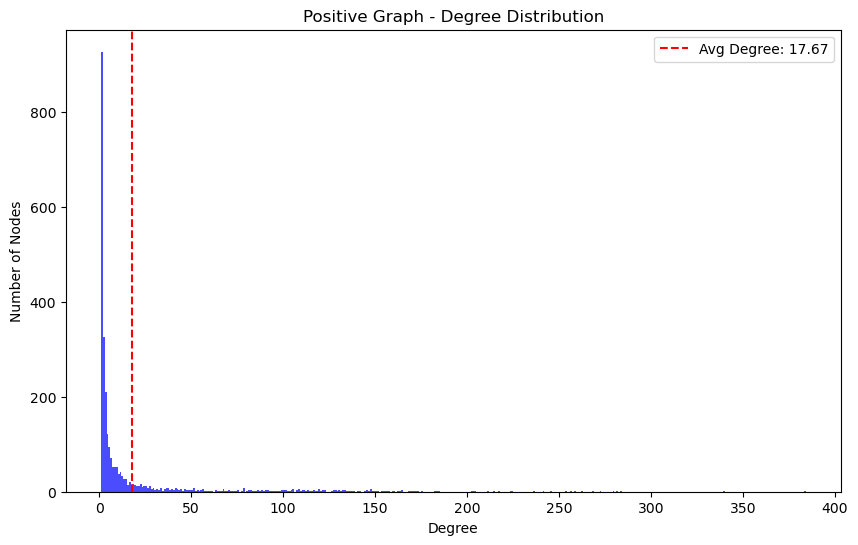

In [54]:
import pygraphviz as pgv
import networkx as nx
import matplotlib.pyplot as plt

# Function to analyze graph
def analyze_graph(G, title="Graph Analysis"):
    # Convert AGraph to NetworkX graph (if necessary)
    if isinstance(G, pgv.AGraph):
        G = nx.nx_agraph.from_agraph(G)  # Convert to NetworkX graph
    
    # Check if the graph is empty
    if len(G.nodes()) == 0:
        print(f"{title} - Graph is empty!")
        return

    # Degree Distribution Plot
    degrees = [G.degree(n) for n in G.nodes()]
    if not degrees:  # If no degrees, exit
        print(f"{title} - No degrees to plot!")
        return
    
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1), color='blue', alpha=0.7)
    plt.title(f"{title} - Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Number of Nodes")
    
    avg_degree = sum(degrees) / len(degrees)
    plt.axvline(avg_degree, color='red', linestyle='--', label=f"Avg Degree: {avg_degree:.2f}")
    plt.legend()

    # Average Degree
    print(f"{title} - Average Degree: {avg_degree:.2f}")

    # Average Path Length (using weak connectivity for directed graphs)
    if nx.is_weakly_connected(G):
        avg_path_length = nx.average_shortest_path_length(G)
        print(f"{title} - Average Path Length: {avg_path_length:.2f}")
    else:
        print(f"{title} - Average Path Length: Not defined for disconnected graph")

    # Clustering Coefficient for directed graphs
    if G.is_directed():
        # Directed Clustering Coefficient (Transitivity for directed graphs)
        clustering_coeff = nx.transitivity(G)
    else:
        # For undirected graphs, you can use the average_clustering function
        clustering_coeff = nx.average_clustering(G)

    print(f"{title} - Average Clustering Coefficient: {clustering_coeff:.2f}")

    # Show the plot
    plt.tight_layout()
    plt.show()

# Analyze Positive, Negative, and Neutral graphs
analyze_graph(G_pos, "Positive Graph")
analyze_graph(G_neg, "Negative Graph")
analyze_graph(G_neu, "Neutral Graph")


In [50]:
# Assuming G_pos is your pygraphviz AGraph object
G_pos_nx = nx.nx_agraph.from_agraph(G_pos)

# Now perform weakly connected components analysis
weakly_connected_components_pos = list(nx.weakly_connected_components(G_pos_nx))
print(len(weakly_connected_components_pos))

G_neg_nx = nx.nx_agraph.from_agraph(G_neg)

# Now perform weakly connected components analysis
weakly_connected_components_neg = list(nx.weakly_connected_components(G_neg_nx))
print(len(weakly_connected_components_neg))

G_neu_nx = nx.nx_agraph.from_agraph(G_neu)

# Now perform weakly connected components analysis
weakly_connected_components_neu = list(nx.weakly_connected_components(G_neu_nx))
print(len(weakly_connected_components_neu))

G_nx = nx.nx_agraph.from_agraph(G)

# Now perform weakly connected components analysis
weakly_connected_components = list(nx.weakly_connected_components(G_nx))
print(len(weakly_connected_components))



4
3
8
1


In [31]:
# Save the graph structure in GraphML format
output_file = "graph_output.graphml"
output_file_pos= "graph_output_pos.graphml"
output_file_neg= "graph_output_neg.graphml"
output_file_neu= "graph_output_neu.graphml"
G.write(output_file)
G_pos.write(output_file_pos)
G_neg.write(output_file_neg)
G_neu.write(output_file_neu)
